The FIFA 19 dataset contains over 18,000 rows with 89 columns. Dataset can be found here - https://www.kaggle.com/karangadiya/fifa19
<br><br><br>

---   

Taken from https://www.kaggle.com/ap1495/fifa-19-classification-regression

### Import required libraries

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')
import pathlib

/home/manujosephv/anaconda3/envs/blog/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
init_notebook_mode(connected=True)
cf.go_offline()

### Read the data

In [5]:
cwd = pathlib.Path.cwd()
data = pd.read_csv(cwd/'fifa_19_dataset'/'data.csv')

print('Number of Categorical Columns: ', len(data.select_dtypes(include=object).columns))
print('Number of Numerical Columns: ', len(data.select_dtypes(exclude=object).columns))

# We have a dataset with 18,207 rows which includes 45 categorical features and 44 numerical features.

# Dealing with unnecessary features and missing values

#Dropping columns which are of very less significance.
data.drop(columns=['Unnamed: 0', 'ID', 'Photo', 'Flag', 'Club Logo', 'Special', 'Real Face', 'Release Clause',
                   'Joined', 'Contract Valid Until'], inplace=True)

#Dropping Loaned From as more than half the values are missing
data.drop(columns=['Loaned From'], inplace=True)

#Still a lot of missing values to deal with. Let us fill in these missing values appropriately and/or drop columns which are not required. <br><br>

#Players who are not part of any club.
data['Club'].fillna(value='No Club', inplace=True)

#Full of NaN values for many features, so drop.
data.drop(index=data[data['Preferred Foot'].isna()].index, inplace=True)

#Can fill in position manually but LS, RS, CF, etc. features have no values, so drop them.
data.drop(index=data[data['Position'].isna()].index, inplace=True)

#Looks like the above features are not set for Goalkeepers. We cannot drop them as it would remove all the goal keepers from our dataset. Instead we will fill these values with 0.

data.fillna(value=0, inplace=True)

Number of Categorical Columns:  45
Number of Numerical Columns:  44


### Converting categorical features to appropriate numerical features

In [6]:
#Function to convert value and wage of the player.
def currencyConverter(val):
    if val[-1] == 'M':
        val = val[1:-1]
        val = float(val) * 1000000
        return val
        
    elif val[-1] == 'K':
        val = val[1:-1]
        val = float(val) * 1000
        return val
    
    else:
        return 0

data['Value in Pounds'] = data['Value'].apply(currencyConverter)
data['Wage in Pounds'] = data['Wage'].apply(currencyConverter)

data.drop(columns=['Value', 'Wage'], inplace=True)

# Value and Wage have been converted.

#Function to convert skill rating at each position.
def skillConverter(val):
    if type(val) == str:
        s1 = val[0:2]
        s2 = val[-1]
        val = int(s1) + int(s2)
        return val
    
    else:
        return val

skill_columns = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
       'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM',
       'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
                      
for col in skill_columns:
    data[col] = data[col].apply(skillConverter)

def height_converter(val):
    f = val.split("'")[0]
    i = val.split("'")[1]
    h = (int(f) * 30.48) + (int(i)*2.54)
    return h

def weight_converter(val):
    w = int(val.split('lbs')[0])
    return w

data['Height in Cms'] = data['Height'].apply(height_converter)
data['Weight in Pounds'] = data['Weight'].apply(weight_converter)

data.drop(columns=['Height', 'Weight'], inplace=True)


# For the remaining columns - **Work Rate, Body Type, Position**, we will not be converting them to numerical features right now. Here, we ensure these features have appropriate values and they will be converted to numerical features when feeding this data to our machine learning models.

data['Body Type'][data['Body Type'] == 'Messi'] = 'Lean'
data['Body Type'][data['Body Type'] == 'C. Ronaldo'] = 'Normal'
data['Body Type'][data['Body Type'] == 'Neymar'] = 'Lean'
data['Body Type'][data['Body Type'] == 'Courtois'] = 'Lean'
#PLAYER_BODY_TYPE_25 is the body type of Mohammed Salah who has a Normal body type.
data['Body Type'][data['Body Type'] == 'PLAYER_BODY_TYPE_25'] = 'Normal'
data['Body Type'][data['Body Type'] == 'Shaqiri'] = 'Stocky'
data['Body Type'][data['Body Type'] == 'Akinfenwa'] = 'Stocky'

# # Let us simplify the above positions into 4 simple categories of - **F**orwards, **M**idfielders, **D**efenders and **G**oal**K**eepers

def position_simplifier(val):
    
    if val == 'RF' or val == 'ST' or val == 'LF' or val == 'RS' or val == 'LS' or val == 'CF':
        val = 'F'
        return val
        
    elif val == 'LW' or val == 'RCM' or val == 'LCM' or val == 'LDM' or val == 'CAM' or val == 'CDM' or val == 'RM' \
         or val == 'LAM' or val == 'LM' or val == 'RDM' or val == 'RW' or val == 'CM' or val == 'RAM':
        val = 'M'
        return val

    
    elif val == 'RCB' or val == 'CB' or val == 'LCB' or val == 'LB' or val == 'RB' or val == 'RWB' or val == 'LWB':
        val = 'D'
        return val
    
    else:
        return val
        

data['Position'] = data['Position'].apply(position_simplifier)

### Visualizations
Plotting a few visualizations which give us more information about the dataset.

**Number of players in each Position**

In [7]:
trace6 = go.Pie(values=data['Position'].value_counts().values,
                labels=data['Position'].value_counts().index.values,
                hole=0.3
               )
 

layout = go.Layout(title='<b>Distribution of Players Position-Wise</b>')

fig = go.Figure(data=[trace6], layout=layout)
py.iplot(fig)

Number of players in each position -
1. Midfielders = 7589
2. Defenders = 5866
3. Forwards = 2667
4. Goal Keepers = 2025
<br><br><br>

**Player Attributes based on Position**

In [8]:
#We are choosing 6 attributes here. We are grouping the data by Position and finding the average of our 6 attributes.
df_skills = data.groupby(by='Position')['Crossing', 'Finishing', 'FKAccuracy', 
                            'StandingTackle', 'Marking', 'Interceptions'].mean().reset_index()

In [9]:
trace5a = go.Scatterpolar(theta=['Crossing', 'Finishing', 'FKAccuracy', 
                                 'StandingTackle', 'Marking', 'Interceptions',
                                 'Crossing'
                                ],
                          r=df_skills[df_skills['Position'] == 'F'][['Crossing', 'Finishing', 'FKAccuracy', 
                                                                     'StandingTackle', 'Marking', 'Interceptions',
                                                                     'Crossing'
                                                                    ]].values[0],
                          fill='toself',
                          name='Forwards'
                         )

trace5b = go.Scatterpolar(theta=['Crossing', 'Finishing', 'FKAccuracy', 
                                 'StandingTackle', 'Marking', 'Interceptions',
                                 'Crossing'
                                ],
                          r=df_skills[df_skills['Position'] == 'M'][['Crossing', 'Finishing', 'FKAccuracy', 
                                                                     'StandingTackle', 'Marking', 'Interceptions',
                                                                     'Crossing'
                                                                    ]].values[0],
                          fill='toself',
                          name='Midfielders'
                         )

trace5c = go.Scatterpolar(theta=['Crossing', 'Finishing', 'FKAccuracy', 
                                 'StandingTackle', 'Marking', 'Interceptions',
                                 'Crossing'
                                ],
                          r=df_skills[df_skills['Position'] == 'D'][['Crossing', 'Finishing', 'FKAccuracy', 
                                                                     'StandingTackle', 'Marking', 'Interceptions',
                                                                     'Crossing'
                                                                    ]].values[0],
                          fill='toself',
                          name='Defenders'
                         )


trace5d = go.Scatterpolar(theta=['Crossing', 'Finishing', 'FKAccuracy', 
                                 'StandingTackle', 'Marking', 'Interceptions',
                                 'Crossing'
                                ],
                          r=df_skills[df_skills['Position'] == 'GK'][['Crossing', 'Finishing', 'FKAccuracy', 
                                                                     'StandingTackle', 'Marking', 'Interceptions',
                                                                     'Crossing'
                                                                    ]].values[0],
                          fill='toself',
                          name='Goal Keepers'
                         )

layout = go.Layout(polar=dict(radialaxis=dict(visible=True,
                                              range=[0, 100]
                                             )
                             
                             ),
                   showlegend=True,
                   title='<b>Attributes by Position</b>'
                  )

fig = go.Figure(data=[trace5a, trace5b, trace5c, trace5d], layout=layout)
py.iplot(fig)

No surprise with Defenders scoring the highest in defending attributes such as StandingTackle, Marking and Interceptions.<br><br>
Midfielders seem like all rounders. They are good at everything but excel in Crossing and FKAccuracy.<br><br>
Forwards' main job is to score goals. Hence, it is expected they score the highest in Finishing.<br><br><br><br>


**Import required libraries**

In [27]:
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from mlxtend.evaluate import feature_importance_permutation
from sklearn.preprocessing import StandardScaler
import joblib

### Predicting *Value in Pounds* from the dataset.

In [11]:
df_ovr = data.copy()
df_ovr.drop(columns=['Name', 'Nationality', 'Club','Wage in Pounds','Overall','Potential','Reactions'], inplace=True)

In [12]:
X = df_ovr.drop(columns=['Value in Pounds'])
X = pd.get_dummies(X)
y = df_ovr['Value in Pounds']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Adding a random feature**

In [14]:
X_train['random'] = np.random.random(len(X_train))
X_test['random'] = np.random.random(len(X_test))

# Linear Regression

In [19]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_tr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
X_ts = scaler.transform(X_test)
prediction = lin_reg.predict(X_ts)
print('R2: ', r2_score(y_test, prediction))

R2:  0.5619002359815191


In [21]:
feat_imp = pd.DataFrame({'features': X_train.columns.tolist(), "coefficients": lin_reg.coef_}).sort_values('coefficients', ascending=False)
feat_imp = feat_imp.head(20)
feat_imp.iplot(kind='bar',
               y='coefficients',
               x='features',
               yTitle='Coefficients',
               xTitle='Features',
               title='Linear Regression',
              )

In [24]:
l1_reg = RidgeCV(cv = 3)
l1_reg.fit(X_tr, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=3, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [25]:
prediction = l1_reg.predict(X_ts)
print('R2: ', r2_score(y_test, prediction))

R2:  0.5624333451775307


In [26]:
feat_imp = pd.DataFrame({'features': X_train.columns.tolist(), "coefficients": l1_reg.coef_}).sort_values('coefficients', ascending=False)
feat_imp = feat_imp.head(20)
feat_imp.iplot(kind='bar',
               y='coefficients',
               x='features',
               yTitle='Coefficients',
               xTitle='Features',
               title='Linear Regression',
              )

In [28]:
l2_reg = LassoCV(cv = 3)
l2_reg.fit(X_tr, y_train)

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [29]:
prediction = l2_reg.predict(X_ts)
print('R2: ', r2_score(y_test, prediction))

R2:  0.5619481592162474


In [30]:
feat_imp = pd.DataFrame({'features': X_train.columns.tolist(), "coefficients": l2_reg.coef_}).sort_values('coefficients', ascending=False)
feat_imp = feat_imp.head(20)
feat_imp.iplot(kind='bar',
               y='coefficients',
               x='features',
               yTitle='Coefficients',
               xTitle='Features',
               title='Linear Regression',
              )

# Random Forest

In [48]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
prediction = rf.predict(X_test)

In [50]:
print('Accuracy Score: ', r2_score(y_test, prediction))

Accuracy Score:  0.9182599113660078


In [53]:
joblib.dump(rf,'fifa_rf_model.sav')

['fifa_rf_model.sav']

## Feature Importances

### Mean Decrease Impurity

In [59]:
feat_imp = pd.DataFrame({'features': X_train.columns.tolist(), "mean_decrease_impurity": rf.feature_importances_}).sort_values('mean_decrease_impurity', ascending=False)
feat_imp = feat_imp.head(20)
feat_imp.iplot(kind='bar',
               y='mean_decrease_impurity',
               x='features',
               yTitle='Mean Decrease Impurity',
               xTitle='Features',
               title='Mean Decrease Impurity',
              )

In [60]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     rf],
                               columns=X_train.columns)
order_column = all_feat_imp_df.mean(axis=0).sort_values(ascending=False).index.tolist()


all_feat_imp_df[order_column[:25]].iplot(kind='box', xTitle = 'Features', yTitle='Mean Decease Impurity', title='Mean Decrease Impurity')

### Permutation Importance

In [61]:
imp_vals, all_trials = feature_importance_permutation(
    predict_method=rf.predict, 
    X=X_test.values,
    y=y_test.values,
    metric='r2',
    num_rounds=50, #This takes sometime. You can reduce this number to make the process faster
    seed=1)

In [77]:
permutation_importance = pd.DataFrame({'features': X_train.columns.tolist(), "permutation_importance": imp_vals}).sort_values('permutation_importance', ascending=False)
permutation_importance = permutation_importance.head(25)
permutation_importance.iplot(kind='bar',
               y='permutation_importance',
               x='features',
               yTitle='Permutation Importance',
               xTitle='Features',
               title='Permutation Importances',
              )

In [66]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=np.transpose(all_trials),
                               columns=X_train.columns, index = range(0,50))
order_column = all_feat_imp_df.mean(axis=0).sort_values(ascending=False).index.tolist()

all_feat_imp_df[order_column[:25]].iplot(kind='box', xTitle = 'Features', yTitle='Permutation Importance', title='Permutation Importances')

In [65]:
joblib.dump(imp_vals,'fifa_permutation_imp_values.sav')
joblib.dump(all_trials,'fifa_permutation_all_trials.sav')

['fifa_permutation_all_trials.sav']

### Shapely Values

In [67]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [68]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [69]:
joblib.dump(explainer, 'fifa_tree_explainer.sav')
joblib.dump(shap_values, 'fifa_tree_explainer_shap_values.sav')

['fifa_tree_explainer_shap_values.sav']

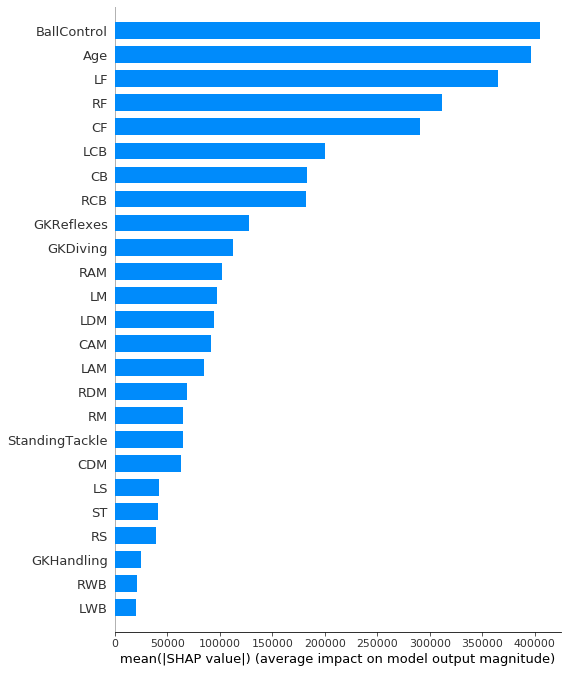

In [73]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type='bar',max_display=25)

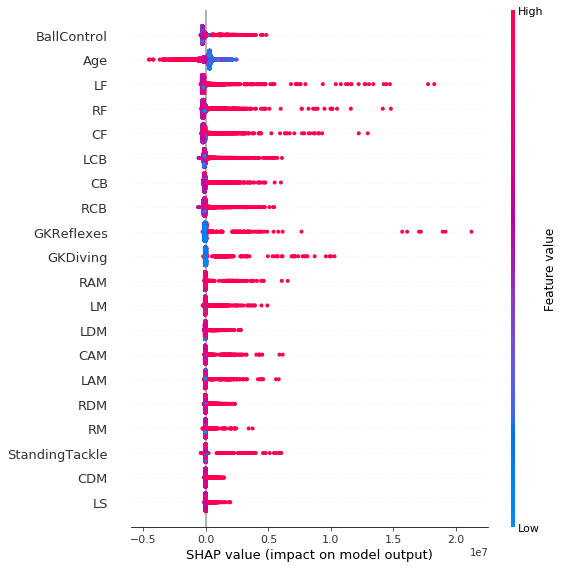

In [78]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

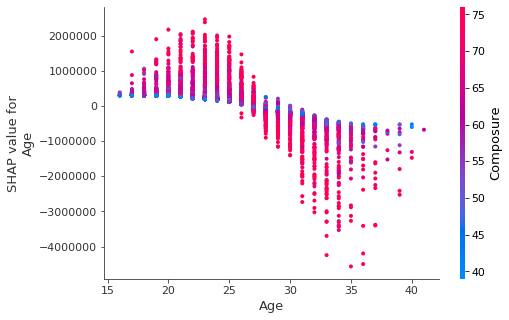

In [79]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age", shap_values, X_test)

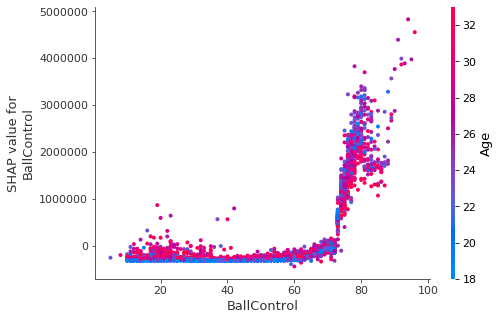

In [80]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("BallControl", shap_values, X_test)

## Individual Predictions

In [188]:
import lime
import lime.lime_tabular

In [196]:
# Creating the Lime Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_test, 
                                                   feature_names=X_train.columns.tolist(), 
                                                   class_names=['Value in Pounds'], 
                                                   mode='regression',
                                                  discretize_continuous=False)

### Messi

In [197]:
_t = X_test.reset_index()
row = _t[_t['index']==0].index.item()
messi = X_test.iloc[row]
y_test.iloc[row]

110500000.0

In [198]:
shap.force_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns,
                link='identity')

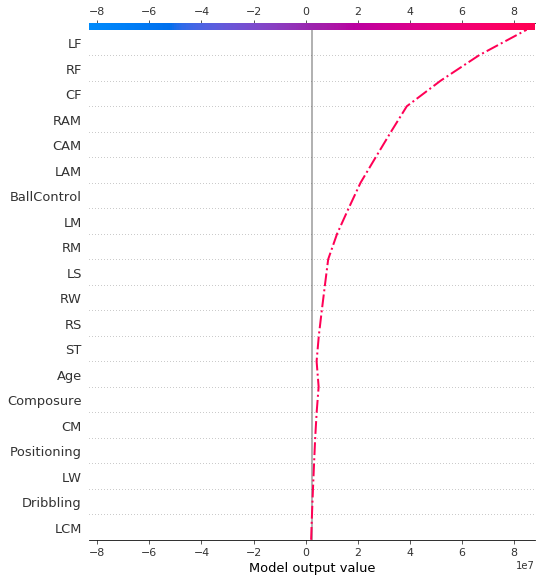

In [199]:
shap.decision_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns.tolist(),
                link='identity', highlight=0)

### LIME Explanation

In [203]:
exp = lime_explainer.explain_instance(X_test.iloc[row], rf.predict, num_features=5)

exp.show_in_notebook(show_table=True)

In [157]:
rf.predict(X_test.iloc[row].to_frame().T)

array([84805000.])

### DeGea

In [204]:
_t = X_test.reset_index()
row = _t[_t['index']==3].index.item()
messi = X_test.iloc[row]
y_test.iloc[row]

72000000.0

In [205]:
shap.force_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns,
                link='identity')

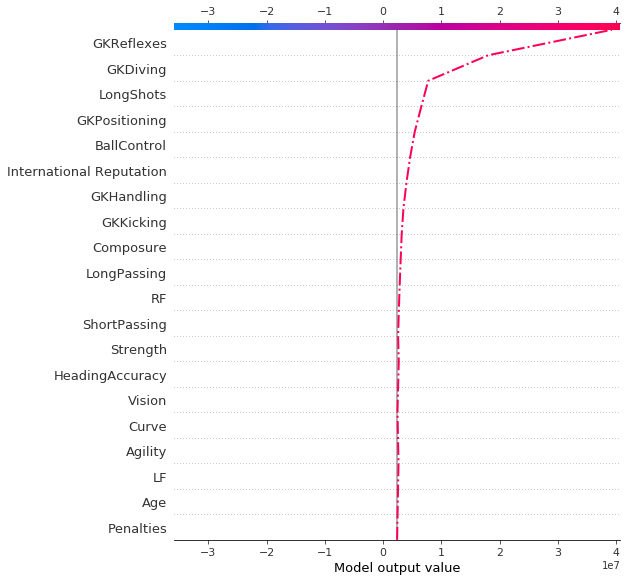

In [206]:
shap.decision_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns.tolist(),
                link='identity', highlight=0)

### LIME Explanation

In [207]:
exp = lime_explainer.explain_instance(X_test.iloc[row], rf.predict, num_features=5)

exp.show_in_notebook(show_table=True)

In [166]:
rf.predict(X_test.iloc[row].to_frame().T)

array([39270000.])

### A. Dzagoev

In [208]:
data.loc[676]

Name                A. Dzagoev
Age                         28
Nationality             Russia
Overall                     79
Potential                   79
                       ...    
GKReflexes                  10
Value in Pounds       1.25e+07
Wage in Pounds            1000
Height in Cms            177.8
Weight in Pounds           165
Name: 676, Length: 78, dtype: object

In [209]:
_t = X_test.reset_index()
row = _t[_t['index']==676].index.item()
messi = X_test.iloc[row]
y_test.iloc[row]

12500000.0

In [210]:
shap.force_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns,
                link='identity')

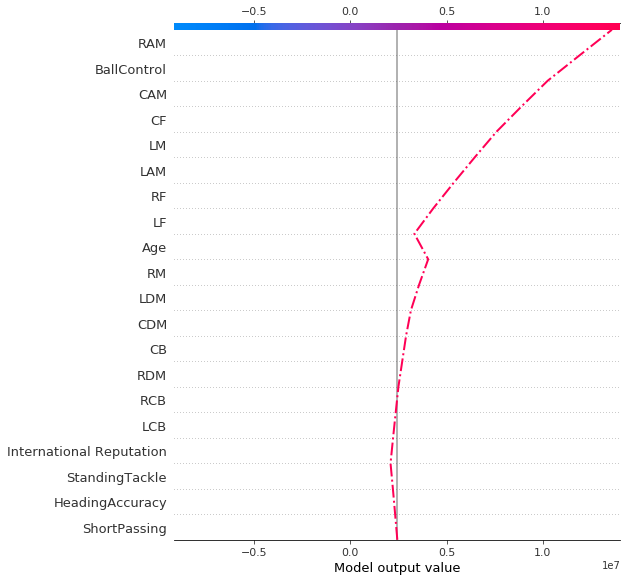

In [211]:
shap.decision_plot(explainer.expected_value, shap_values[row], feature_names=X_train.columns.tolist(),
                link='identity', highlight=0)

### LIME Explanation

In [212]:
exp = lime_explainer.explain_instance(X_test.iloc[row], rf.predict, num_features=5)

exp.show_in_notebook(show_table=True)

In [187]:
rf.predict(X_test.iloc[row].to_frame().T)

array([13580000.])